# 🫀 Heart Disease Prediction Project
**Goal:** Predict whether a patient has heart disease based on clinical attributes.
This project uses modern preprocessing, balancing, and XGBoost modeling for a complete and professional touch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
sns.set()

# Load dataset
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
print(data.isnull().sum())
data.describe(include='all')

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


## 📊 Data Visualization

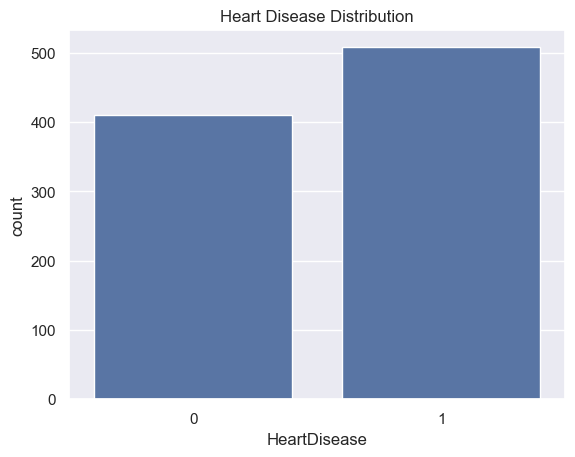

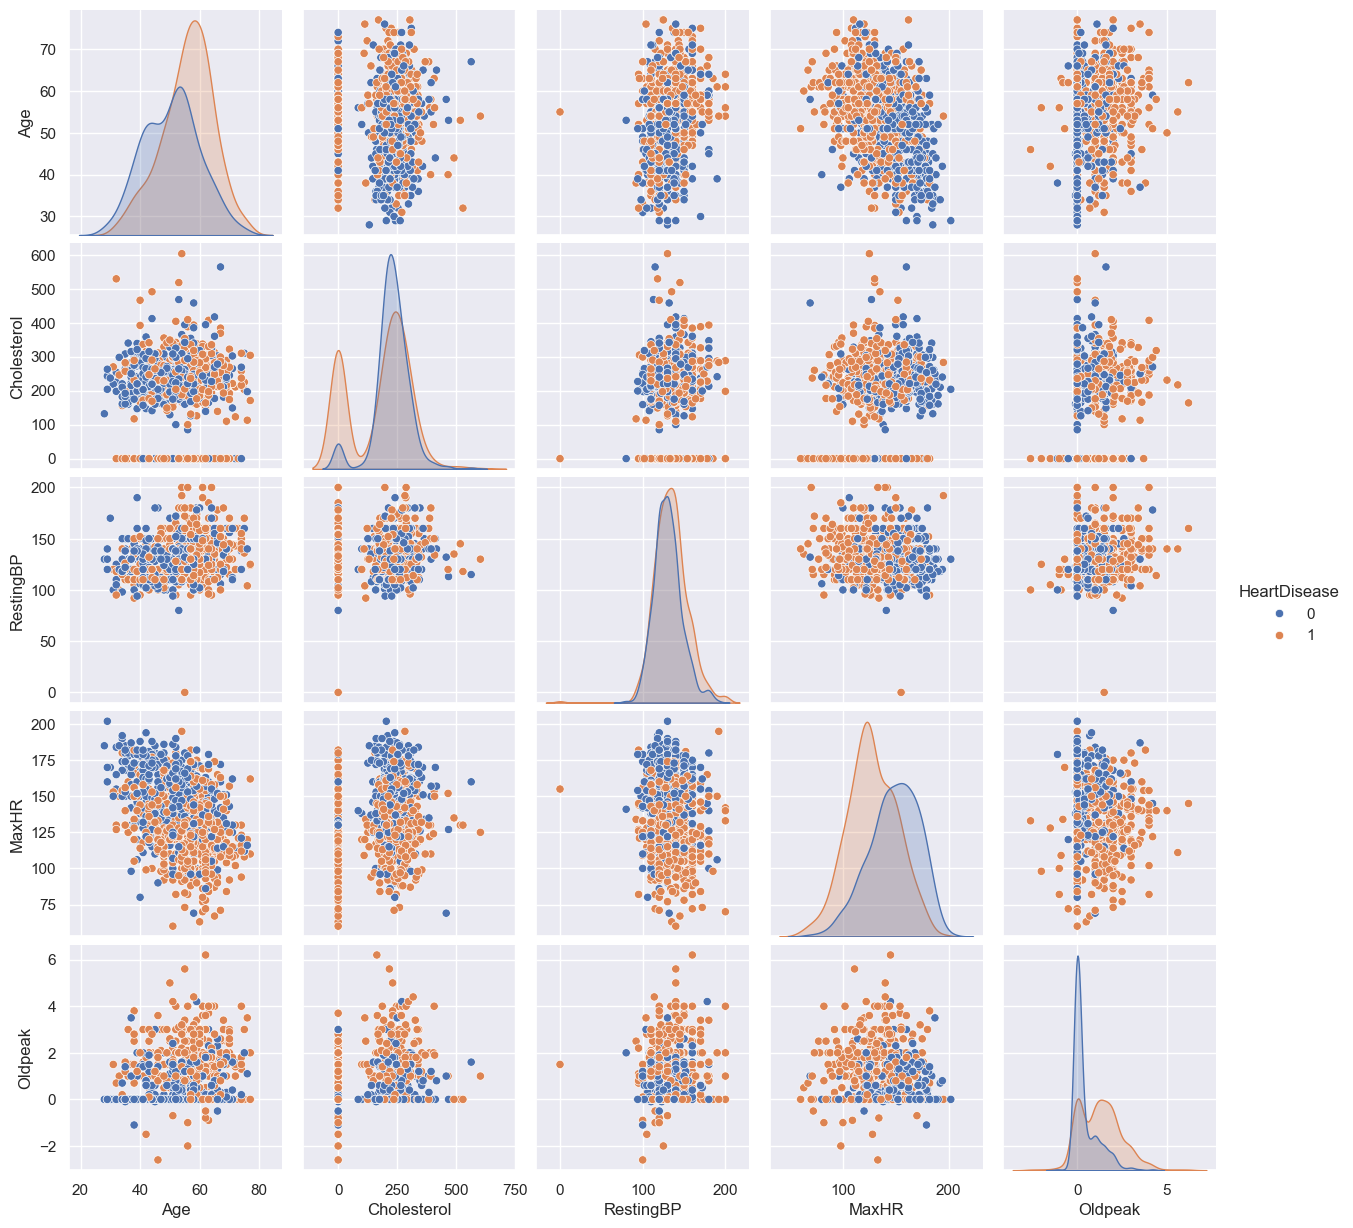

In [8]:
# Countplot for target
sns.countplot(x='HeartDisease', data=data)
plt.title('Heart Disease Distribution')
plt.show()

# Pairplot for key variables
sns.pairplot(data[['Age', 'Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak', 'HeartDisease']], hue='HeartDisease')

In [9]:
# Encode categorical columns
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
data['ST_Slope'] = data['ST_Slope'].map({'Up': 1, 'Flat': 0, 'Down': -1})
data = pd.get_dummies(data, columns=['ChestPainType', 'RestingECG'], drop_first=True)
data.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,1,0,True,False,False,True,False
1,49,0,160,180,0,156,0,1.0,0,1,False,True,False,True,False
2,37,1,130,283,0,98,0,0.0,1,0,True,False,False,False,True
3,48,0,138,214,0,108,1,1.5,0,1,False,False,False,True,False
4,54,1,150,195,0,122,0,0.0,1,0,False,True,False,True,False


In [10]:
# Balance the dataset by under-sampling males
male = data[data['Sex'] == 1]
female = data[data['Sex'] == 0]
male_downsampled = male.sample(int(len(female) * (57.5 / 42.5)), random_state=42)
data_balanced = pd.concat([male_downsampled, female])
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
data_balanced['Sex'].value_counts(normalize=True)

Sex
1    0.57489
0    0.42511
Name: proportion, dtype: float64

In [20]:
# Define input and output
x = data_balanced.drop('HeartDisease', axis=1)
y = data_balanced['HeartDisease']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [18]:
# Model using XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)

C:\Users\ryash\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [09:16:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## ✅ Evaluation Metrics

In [22]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8241758241758241

Confusion Matrix:
 [[44  8]
 [ 8 31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        52
           1       0.79      0.79      0.79        39

    accuracy                           0.82        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.82      0.82      0.82        91

